# PREDICCION DE PRECIOS DE AGUACATE EN EEUU





# Enunciado del Problema

- Los datos representan ventas semanales desde 2015 a 2018 a nivel de todos los EEUU. 
- Los datos provienen directamente de las cajas registradoras basados en ventas de aguacate variedad Hass. 
- El precio promedio de los aguacates reflejan el costo por unidad, aún cuando estos se vendan por bolsas. 
- Los códigos (Product Lookup codes ó PLU) en la tabla son solo de aguacates Hass.  No se incluyen otras variedades.

Columnas relevantes en el conjunto de datos:

- Date - la fecha de la observación
- AveragePrice - el precio promedio de una unidad
- type - convencional u orgánico
- year - el año
- Region - la ciudad o región de la observación
- Total Volume - número total de aguacates vendidos
- 4046 - número total de aguacates con PLU 4046 vendidos
- 4225 - número total de aguacates con PLU 4225 vendidos
- 4770 - número total de aguacates con PLU 4770 vendidos



# Importar las librerías

In [ ]:

! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [58]:
!pip install prophet

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [73]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from pandas_profiling import ProfileReport
from quickda.explore_data import *
from quickda.clean_data import *
from quickda.explore_numeric import *
from quickda.explore_categoric import *
from quickda.explore_numeric_categoric import *
from quickda.explore_time_series import *
from prophet import Prophet

# Carga de datos

In [50]:
avocado_df = pd.read_csv("aguacates_EEUU.csv")
print(avocado_df.head())
print(avocado_df.shape)

   Unnamed: 0        Date  AveragePrice  Total Volume     4046       4225  \
0           0  2015-12-27          1.33      64236.62  1036.74   54454.85   
1           1  2015-12-20          1.35      54876.98   674.28   44638.81   
2           2  2015-12-13          0.93     118220.22   794.70  109149.67   
3           3  2015-12-06          1.08      78992.15  1132.00   71976.41   
4           4  2015-11-29          1.28      51039.60   941.48   43838.39   

     4770  Total Bags  Small Bags  Large Bags  XLarge Bags          type  \
0   48.16     8696.87     8603.62       93.25          0.0  conventional   
1   58.33     9505.56     9408.07       97.49          0.0  conventional   
2  130.50     8145.35     8042.21      103.14          0.0  conventional   
3   72.58     5811.16     5677.40      133.76          0.0  conventional   
4   75.78     6183.95     5986.26      197.69          0.0  conventional   

   year  region  
0  2015  Albany  
1  2015  Albany  
2  2015  Albany  
3  2015 

# Explorar el conjunto de datos  

In [ ]:
#Correr para generar reporte
profile = ProfileReport(avocado_df)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [31]:
print(avocado_df.info())
print(avocado_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    18249 non-null  int64  
 1   Date          18249 non-null  object 
 2   AveragePrice  18249 non-null  float64
 3   Total Volume  18249 non-null  float64
 4   4046          18249 non-null  float64
 5   4225          18249 non-null  float64
 6   4770          18249 non-null  float64
 7   Total Bags    18249 non-null  float64
 8   Small Bags    18249 non-null  float64
 9   Large Bags    18249 non-null  float64
 10  XLarge Bags   18249 non-null  float64
 11  type          18249 non-null  object 
 12  year          18249 non-null  int64  
 13  region        18249 non-null  object 
dtypes: float64(9), int64(2), object(3)
memory usage: 1.9+ MB
None
         Unnamed: 0  AveragePrice  Total Volume          4046          4225  \
count  18249.000000  18249.000000  1.824900e+04  1.824900

In [51]:
avocado_df = clean(avocado_df, method="standardize")

In [ ]:
eda_num(avocado_df)

# Asegurar que estén los datos en orden cronológico

In [52]:
avocado_df["date"] = pd.to_datetime(avocado_df["date"])
#sort by date
avocado_df = avocado_df.sort_values(by="date")
avocado_df.head()

unnamed:_0       date  averageprice  total_volume     4046      4225  \
11569          51 2015-01-04          1.75      27365.89  9307.34   3844.81   
9593           51 2015-01-04          1.49      17723.17  1189.35  15628.27   
10009          51 2015-01-04          1.68       2896.72   161.68    206.96   
1819           51 2015-01-04          1.52      54956.80  3013.04  35456.88   
9333           51 2015-01-04          1.64       1505.12     1.27   1129.50   

          4770  total_bags  small_bags  large_bags  xlarge_bags          type  \
11569   615.28    13598.46    13061.10      537.36          0.0       organic   
9593      0.00      905.55      905.55        0.00          0.0       organic   
10009     0.00     2528.08     2528.08        0.00          0.0       organic   
1819   1561.70    14925.18    11264.80     3660.38          0.0  conventional   
9333      0.00      374.35      186.67      187.68          0.0       organic   

       year              region  
11569  2015           Southeast  
9593   2015             Chicago  
10009  2015  HarrisburgScranton  
1819   2015          Pittsburgh  
9333   2015               Boise

# Realizar una gráfica de precios promedio vrs fecha

¿Cuál es la tendencia a nivel nacional?

In [53]:
avocado_df.set_index("date", inplace=True)
avocado_series = avocado_df.groupby(avocado_df.index).mean()

<AxesSubplot:xlabel='date'>

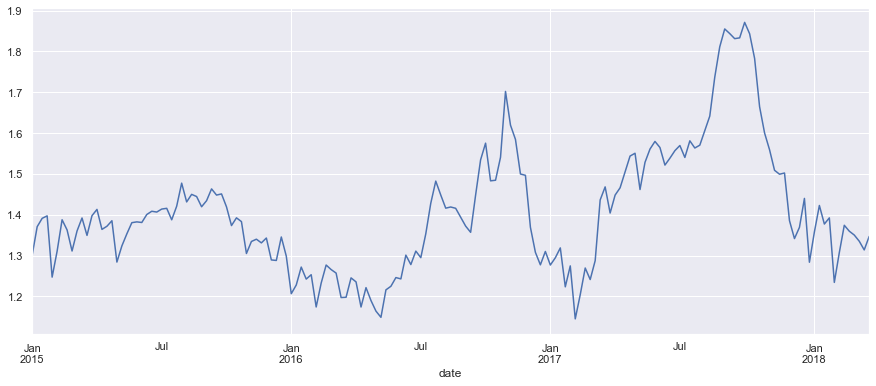

In [54]:
#Graficar precios vs fecha
avocado_series['averageprice'].plot(figsize=(15, 6))

# Realizar una gráfica de barras para ver el número de regiones

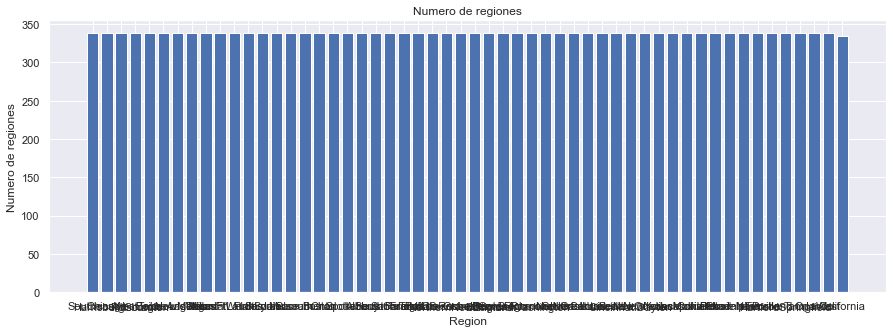

In [55]:
#Grafica de barras para numero de regiones
plt.figure(figsize=(15,5))
plt.bar(avocado_df["region"].unique(), avocado_df["region"].value_counts())
plt.title("Numero de regiones")
plt.xlabel("Region")
plt.ylabel("Numero de regiones")
plt.show()

# Realizar una gráfica de barras para ver de qué años se tiene información

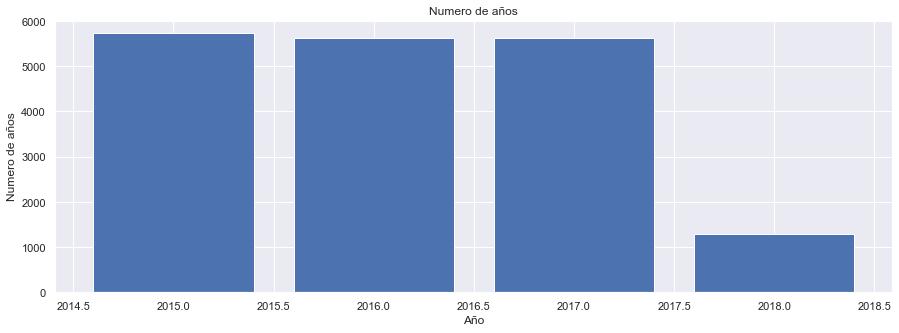

In [56]:
#Grafica de barras para ver años
plt.figure(figsize=(15,5))
plt.bar(avocado_df["year"].unique(), avocado_df["year"].value_counts())
plt.title("Numero de años")
plt.xlabel("Año")
plt.ylabel("Numero de años")
plt.show()


# Preparar los datos para que se acoplen a lo que requiere el modelo a utilizar

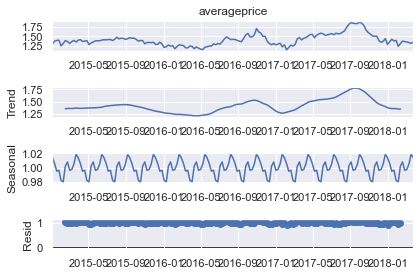

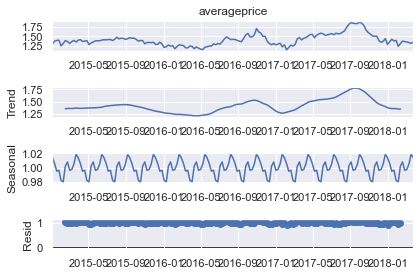

In [57]:
#Analisis de los componentes
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(avocado_series['averageprice'],period=12,model='multiplicative')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

decomposition.plot()

In [68]:
df_prophet = avocado_series[['averageprice']].copy()
#rename
df_prophet = df_prophet.rename(columns={'averageprice':'y', 'date':'ds'})
df_prophet['date'] = df_prophet.index
df_prophet = df_prophet.reset_index(drop=True)
#rename dates 
df_prophet['ds'] = df_prophet['date']
df_prophet = df_prophet.drop(columns=['date'])
df_prophet



y         ds
0    1.301296 2015-01-04
1    1.370648 2015-01-11
2    1.391111 2015-01-18
3    1.397130 2015-01-25
4    1.247037 2015-02-01
..        ...        ...
164  1.359630 2018-02-25
165  1.350185 2018-03-04
166  1.335093 2018-03-11
167  1.313704 2018-03-18
168  1.346852 2018-03-25

[169 rows x 2 columns]

# Realizar predicciones

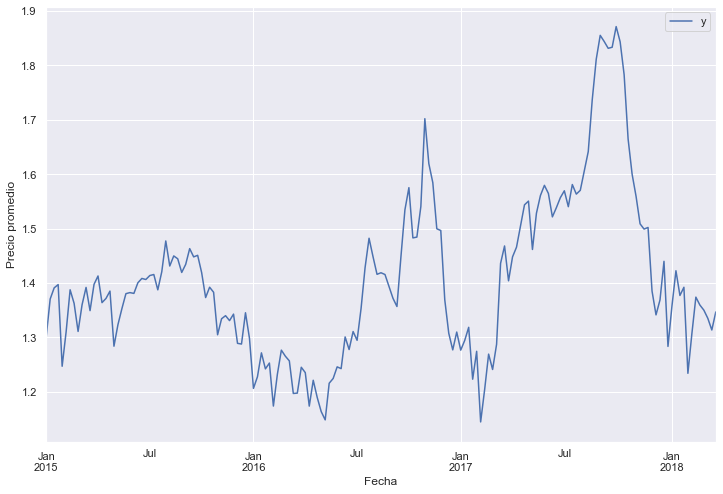

In [69]:
#Visualizar datos
ax = df_prophet.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Precio promedio')
ax.set_xlabel('Fecha')
plt.show()

# Creación y ajuste del modelo

In [74]:
my_model = Prophet(interval_width=0.95)
my_model.fit(df_prophet)
future_dates = my_model.make_future_dataframe(periods=365)
future_dates.tail()

11:32:09 - cmdstanpy - INFO - Chain [1] start processing
11:32:10 - cmdstanpy - INFO - Chain [1] done processing


ds
529 2019-03-21
530 2019-03-22
531 2019-03-23
532 2019-03-24
533 2019-03-25

# Pronosticar hacia el futuro un año (365 días)

In [75]:
prediction = my_model.predict(future_dates)

In [76]:
prediction[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
529 2019-03-21  1.258632    1.072988    1.480804
530 2019-03-22  1.260506    1.066200    1.465132
531 2019-03-23  1.262712    1.056733    1.456455
532 2019-03-24  1.265224    1.067649    1.470205
533 2019-03-25  1.268008    1.063556    1.458025

# Graficar los datos históricos y los del futuro

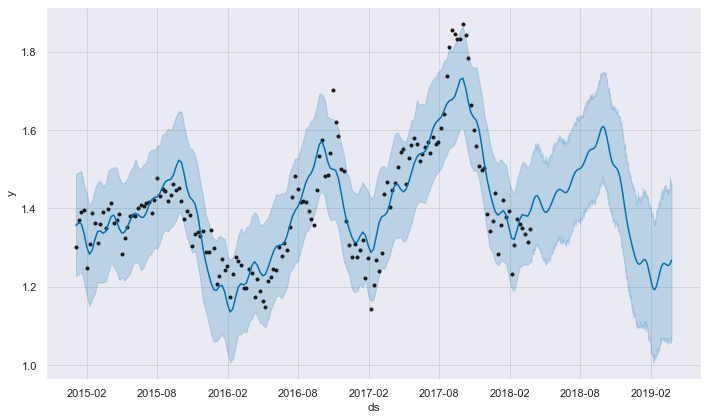

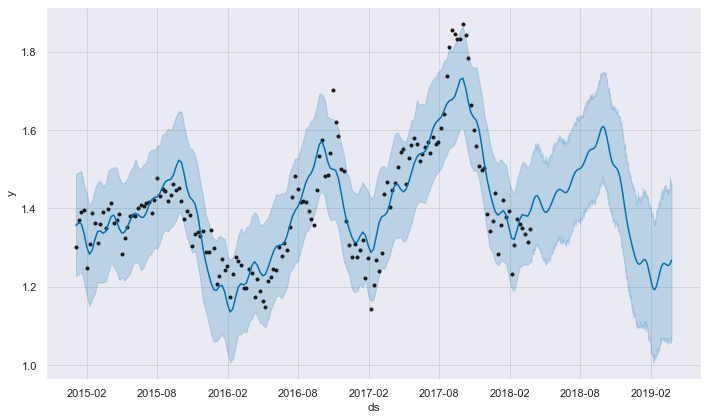

In [77]:
#plot
my_model.plot(prediction, uncertainty=True)

# Graficar los componentes del pronóstico

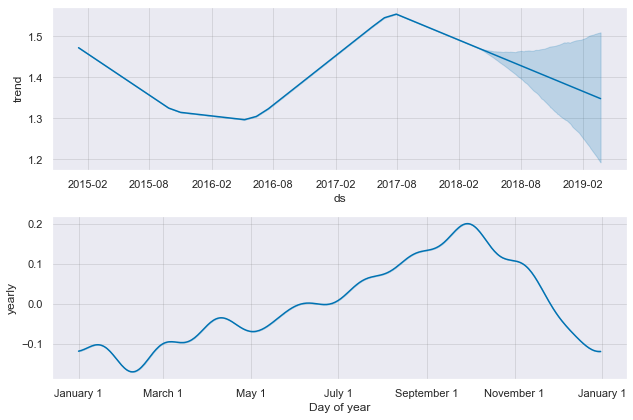

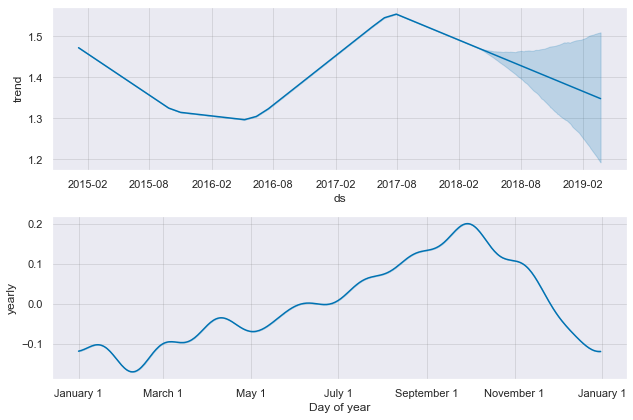

In [78]:
#plot components
my_model.plot_components(prediction)

# PARTE 2

### Repetir el ejercicio pero solo con la región oeste "West" de los EEUU

### Leer el archivo de datos

### Por si acaso no están ordenadas las observaciones

# Graficar el precio promedio vs fecha

### ¿Es diferente la tendencia comparado a la tendencia nacional?

# Crear el modelo y ajustarlo con los datos

### Preparar los datos para que sean aceptados por el modelo a usar

# Pronosticar al futuro un año (365 días)

# Graficar datos históricos y pronosticados